# Load candidates

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
CACHE = '/home/anhphantq/vdb/cache_train'
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
train_data = []
# train_data = []
num_cands = []

with open(CACHE + '/metadata', 'rb') as f:
  metadata = pickle.load(f)

num_frags = min(metadata['num_frags'], 80)
max_session = metadata['max_session']


for i in tqdm(range(num_frags)):
    train_data.append(pd.read_parquet(CACHE + f'/data_{i}.parquet'))






100%|██████████| 80/80 [00:06<00:00, 11.47it/s]


In [3]:
train_data = pd.concat(train_data)

In [4]:
candidates = train_data
candidates.shape

(29176803, 159)

In [5]:
import pandas as pd
pd.set_option('display.max_columns', candidates.shape[1])

In [6]:
print(candidates.head())


         user        item  consistency  degree  fitness  inter_carts  \
0  12022257.0  12912724.0     0.073698     NaN      NaN          NaN   
1  12022257.0  12936332.0     0.073698     NaN      NaN          NaN   
2  12022257.0  12959602.0     0.073698     NaN      NaN          NaN   
3  12022257.0  12962444.0     0.073698     NaN      NaN          NaN   
4  12022257.0  12969468.0     0.073698     NaN      NaN          NaN   

   inter_clicks  inter_durability  inter_fts  inter_lts  inter_num_interacts  \
0           NaN               NaN        NaN        NaN                  NaN   
1           NaN               NaN        NaN        NaN                  NaN   
2           NaN               NaN        NaN        NaN                  NaN   
3           NaN               NaN        NaN        NaN                  NaN   
4           NaN               NaN        NaN        NaN                  NaN   

   inter_num_sub  inter_orders  inter_time_decay  is_level1  item_degree  \
0         

# Train params

In [7]:
from xgb_utils import *

PARAMS = {
    'eta': 0.5,
    'min_child_weight': 1000,
    'num_parallel_tree': 1,
    'tree_method': 'hist',
    'max_bin': 256,
    'objective':'rank:pairwise',   
    'max_depth': 7,
    'reg_alpha': 0.041545473,
    'reg_lambda': 0.0735294,
    'gamma': 0.0222415,
}
N_SPLITS = 5
NUM_TREE = 1000
MODEL_PATH = '/home/anhphantq/alpha_xgboost'
VERSION = '3'

# Train for each type

In [8]:
from xgb_utils import get_len_group

In [9]:
candidates

,user,item,consistency,degree,fitness,inter_carts,inter_clicks,inter_durability,inter_fts,inter_lts,inter_num_interacts,inter_num_sub,inter_orders,inter_time_decay,is_level1,item_degree,item_glob_first_action,item_glob_item_glob_durability,item_glob_last_action,item_glob_time_decay_sum,item_glob_time_decay_sum_cart,item_glob_time_decay_sum_click,item_glob_time_decay_sum_order,item_pr,item_recent_degree,item_recent_pr,lincom_recent_day_1_10_1_3,lincom_recent_day_1_10_3_1,lincom_recent_day_1_1_10_3,lincom_recent_day_1_1_3_10,lincom_recent_day_1_3_10_1,lincom_recent_day_1_3_1_10,lincom_recent_day_2_10_1_3,lincom_recent_day_2_10_3_1,lincom_recent_day_2_1_10_3,lincom_recent_day_2_1_3_10,lincom_recent_day_2_3_10_1,lincom_recent_day_2_3_1_10,lincom_recent_day_3_10_1_3,lincom_recent_day_3_10_3_1,lincom_recent_day_3_1_10_3,lincom_recent_day_3_1_3_10,lincom_recent_day_3_3_10_1,lincom_recent_day_3_3_1_10,lincom_recent_day_4_10_1_3,lincom_recent_day_4_10_3_1,lincom_recent_day_4_1_10_3,lincom_recent_day_4_1_3_10,lincom_recent_day_4_3_10_1,lincom_recent_day_4_3_1_10,lincom_recent_day_5_10_1_3,lincom_recent_day_5_10_3_1,lincom_recent_day_5_1_10_3,lincom_recent_day_5_1_3_10,lincom_recent_day_5_3_10_1,lincom_recent_day_5_3_1_10,lincom_recent_day_6_10_1_3,lincom_recent_day_6_10_3_1,lincom_recent_day_6_1_10_3,lincom_recent_day_6_1_3_10,lincom_recent_day_6_3_10_1,lincom_recent_day_6_3_1_10,lincom_recent_day_7_10_1_3,lincom_recent_day_7_10_3_1,lincom_recent_day_7_1_10_3,lincom_recent_day_7_1_3_10,lincom_recent_day_7_3_10_1,lincom_recent_day_7_3_1_10,num_actions,num_appearance_top_20_buy2buy,num_appearance_top_20_buys,num_appearance_top_20_clicks,num_carts,num_clicks,num_orders,num_sub,pr,qou_cocart_sub_coef_mean,qou_cocart_sub_coef_sqrt_num_cousers,qou_cocart_time_decay_mean,qou_cocart_time_decay_sqrt_num_cousers,qou_coclick_sub_coef_mean,qou_coclick_sub_coef_sqrt_num_cousers,qou_coclick_time_decay_mean,qou_coclick_time_decay_sqrt_num_cousers,qou_coorder_sub_coef_mean,qou_coorder_sub_coef_sqrt_num_cousers,qou_coorder_time_decay_mean,qou_coorder_time_decay_sqrt_num_cousers,qou_lincom_sub_coef_10_1_3_mean,qou_lincom_sub_coef_10_3_1_mean,qou_lincom_sub_coef_1_10_3_mean,qou_lincom_sub_coef_1_3_10_mean,qou_lincom_sub_coef_3_10_1_mean,qou_lincom_sub_coef_3_1_10_mean,qou_lincom_time_decay_10_1_3_mean,qou_lincom_time_decay_10_3_1_mean,qou_lincom_time_decay_1_10_3_mean,qou_lincom_time_decay_1_3_10_mean,qou_lincom_time_decay_3_10_1_mean,qou_lincom_time_decay_3_1_10_mean,qou_num_appearance_mean,qou_num_appearance_sqrt_num_cousers,qou_num_cosub_mean,qou_num_cosub_sqrt_num_cousers,recent_day1_type0,recent_day1_type1,recent_day1_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day4_type0,recent_day4_type1,recent_day4_type2,recent_day5_type0,recent_day5_type1,recent_day5_type2,recent_day6_type0,recent_day6_type1,recent_day6_type2,recent_day7_type0,recent_day7_type1,recent_day7_type2,recent_degree,recent_inter_day1_type0,recent_inter_day1_type1,recent_inter_day1_type2,recent_inter_day2_type0,recent_inter_day2_type1,recent_inter_day2_type2,recent_inter_day3_type0,recent_inter_day3_type1,recent_inter_day3_type2,recent_inter_day4_type0,recent_inter_day4_type1,recent_inter_day4_type2,recent_inter_day5_type0,recent_inter_day5_type1,recent_inter_day5_type2,recent_inter_day6_type0,recent_inter_day6_type1,recent_inter_day6_type2,recent_inter_day7_type0,recent_inter_day7_type1,recent_inter_day7_type2,recent_num_carts,recent_num_clicks,recent_num_orders,recent_pr,user_degree,user_pr,user_recent_degree,user_recent_pr,weight_top_20_buy2buy,weight_top_20_buys,weight_top_20_clicks
0,12022257.0,12912724.0,0.073698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,0.419977,20.426308,20.846285,38.380348,2.819298,34.283596,1.277451,2.342453e-07,22.0,2.510658e-07,324.023865,248.103119,140.187088,405.909668,105.118973,446.762299,21.0,23.0,12.0,5.0,16.0,7.0,40.0,40.0,4.0,4.0,12.0,12.0,30.0,30.0,3.0,3.0,9.0,9.0

In [10]:
import pandas as pd 
import numpy as np
tar = pd.read_parquet('/home/anhphantq/otto/splitted_data/test_labels.parquet')
tar = tar.loc[(tar['session'] <= candidates['user'].max()) & (tar['session'] >= candidates['user'].min()) ]
aids = tar.ground_truth.explode().astype('int32').rename('item')
tar = tar[['session', 'type']].rename({'session':'user'},axis=1)
tar = tar.merge(aids, left_index=True, right_index=True, how='left')
tar['type'] = tar['type'].apply(lambda x: 0 if x == 'clicks' else 1 if x == 'carts' else 2)
tar['label'] = 1
tar['item'] = tar['item'] + max_session
tar['user_type'] = tar['user'] * 10 + tar['type']

In [11]:
num_cands = candidates[['user', 'item']].groupby('user').count().reset_index()
num_cands['num_cands'] = num_cands['item']
del num_cands['item'] 

num_cands = candidates.merge(num_cands,on=['user'],how='left')['num_cands'].values


In [12]:
candidates

,user,item,consistency,degree,fitness,inter_carts,inter_clicks,inter_durability,inter_fts,inter_lts,inter_num_interacts,inter_num_sub,inter_orders,inter_time_decay,is_level1,item_degree,item_glob_first_action,item_glob_item_glob_durability,item_glob_last_action,item_glob_time_decay_sum,item_glob_time_decay_sum_cart,item_glob_time_decay_sum_click,item_glob_time_decay_sum_order,item_pr,item_recent_degree,item_recent_pr,lincom_recent_day_1_10_1_3,lincom_recent_day_1_10_3_1,lincom_recent_day_1_1_10_3,lincom_recent_day_1_1_3_10,lincom_recent_day_1_3_10_1,lincom_recent_day_1_3_1_10,lincom_recent_day_2_10_1_3,lincom_recent_day_2_10_3_1,lincom_recent_day_2_1_10_3,lincom_recent_day_2_1_3_10,lincom_recent_day_2_3_10_1,lincom_recent_day_2_3_1_10,lincom_recent_day_3_10_1_3,lincom_recent_day_3_10_3_1,lincom_recent_day_3_1_10_3,lincom_recent_day_3_1_3_10,lincom_recent_day_3_3_10_1,lincom_recent_day_3_3_1_10,lincom_recent_day_4_10_1_3,lincom_recent_day_4_10_3_1,lincom_recent_day_4_1_10_3,lincom_recent_day_4_1_3_10,lincom_recent_day_4_3_10_1,lincom_recent_day_4_3_1_10,lincom_recent_day_5_10_1_3,lincom_recent_day_5_10_3_1,lincom_recent_day_5_1_10_3,lincom_recent_day_5_1_3_10,lincom_recent_day_5_3_10_1,lincom_recent_day_5_3_1_10,lincom_recent_day_6_10_1_3,lincom_recent_day_6_10_3_1,lincom_recent_day_6_1_10_3,lincom_recent_day_6_1_3_10,lincom_recent_day_6_3_10_1,lincom_recent_day_6_3_1_10,lincom_recent_day_7_10_1_3,lincom_recent_day_7_10_3_1,lincom_recent_day_7_1_10_3,lincom_recent_day_7_1_3_10,lincom_recent_day_7_3_10_1,lincom_recent_day_7_3_1_10,num_actions,num_appearance_top_20_buy2buy,num_appearance_top_20_buys,num_appearance_top_20_clicks,num_carts,num_clicks,num_orders,num_sub,pr,qou_cocart_sub_coef_mean,qou_cocart_sub_coef_sqrt_num_cousers,qou_cocart_time_decay_mean,qou_cocart_time_decay_sqrt_num_cousers,qou_coclick_sub_coef_mean,qou_coclick_sub_coef_sqrt_num_cousers,qou_coclick_time_decay_mean,qou_coclick_time_decay_sqrt_num_cousers,qou_coorder_sub_coef_mean,qou_coorder_sub_coef_sqrt_num_cousers,qou_coorder_time_decay_mean,qou_coorder_time_decay_sqrt_num_cousers,qou_lincom_sub_coef_10_1_3_mean,qou_lincom_sub_coef_10_3_1_mean,qou_lincom_sub_coef_1_10_3_mean,qou_lincom_sub_coef_1_3_10_mean,qou_lincom_sub_coef_3_10_1_mean,qou_lincom_sub_coef_3_1_10_mean,qou_lincom_time_decay_10_1_3_mean,qou_lincom_time_decay_10_3_1_mean,qou_lincom_time_decay_1_10_3_mean,qou_lincom_time_decay_1_3_10_mean,qou_lincom_time_decay_3_10_1_mean,qou_lincom_time_decay_3_1_10_mean,qou_num_appearance_mean,qou_num_appearance_sqrt_num_cousers,qou_num_cosub_mean,qou_num_cosub_sqrt_num_cousers,recent_day1_type0,recent_day1_type1,recent_day1_type2,recent_day2_type0,recent_day2_type1,recent_day2_type2,recent_day3_type0,recent_day3_type1,recent_day3_type2,recent_day4_type0,recent_day4_type1,recent_day4_type2,recent_day5_type0,recent_day5_type1,recent_day5_type2,recent_day6_type0,recent_day6_type1,recent_day6_type2,recent_day7_type0,recent_day7_type1,recent_day7_type2,recent_degree,recent_inter_day1_type0,recent_inter_day1_type1,recent_inter_day1_type2,recent_inter_day2_type0,recent_inter_day2_type1,recent_inter_day2_type2,recent_inter_day3_type0,recent_inter_day3_type1,recent_inter_day3_type2,recent_inter_day4_type0,recent_inter_day4_type1,recent_inter_day4_type2,recent_inter_day5_type0,recent_inter_day5_type1,recent_inter_day5_type2,recent_inter_day6_type0,recent_inter_day6_type1,recent_inter_day6_type2,recent_inter_day7_type0,recent_inter_day7_type1,recent_inter_day7_type2,recent_num_carts,recent_num_clicks,recent_num_orders,recent_pr,user_degree,user_pr,user_recent_degree,user_recent_pr,weight_top_20_buy2buy,weight_top_20_buys,weight_top_20_clicks
0,12022257.0,12912724.0,0.073698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,0.419977,20.426308,20.846285,38.380348,2.819298,34.283596,1.277451,2.342453e-07,22.0,2.510658e-07,324.023865,248.103119,140.187088,405.909668,105.118973,446.762299,21.0,23.0,12.0,5.0,16.0,7.0,40.0,40.0,4.0,4.0,12.0,12.0,30.0,30.0,3.0,3.0,9.0,9.0

In [13]:
labels = []
for i in range(3):
  tar_small = tar[tar['type'] == i]
  
  labels.append(candidates.merge(tar_small[['item', 'label', 'user']],on=['user','item'],how='left').fillna(0)['label'].values.astype(int))
  
  



In [14]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import os
import shutil
import matplotlib.pyplot as plt
def train(t, id_type):
  global candidates, num_cands, labels
  name = f'/{t}_only_'
  try:
    shutil.rmtree(MODEL_PATH + name + VERSION)
  except:
    pass
  else:
    print('remove old version')
  
  


  skf = GroupKFold(n_splits=N_SPLITS)
  fig, axs = plt.subplots(1,N_SPLITS, figsize = (N_SPLITS * 10, 10))
  for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, labels[id_type], groups=candidates['user'] )):

      X_train = candidates.iloc[train_idx, 2:]
      y_train = labels[id_type][train_idx]
      X_valid = candidates.iloc[valid_idx, 2:]
      y_valid = labels[id_type][valid_idx]

      dtrain = xgb.DMatrix(X_train, y_train, nthread = os.cpu_count()) 
      dtrain.set_group(get_len_group(train_idx, num_cands))
      dvalid = xgb.DMatrix(X_valid, y_valid, nthread = os.cpu_count()) 
      dvalid.set_group(get_len_group(valid_idx, num_cands))
      
      xgb_parms = {'nthread' : os.cpu_count(),
      **PARAMS}
      model = xgb.train(xgb_parms, 
          dtrain=dtrain,
          evals=[(dtrain,'train'),(dvalid,'valid')],
          num_boost_round=NUM_TREE,
          verbose_eval=5,
          early_stopping_rounds= 30, )
      try:
        os.mkdir(MODEL_PATH + name + VERSION)
      except:
        pass
      model.save_model(MODEL_PATH + name + VERSION + f'/XGB_fold{fold}.xgb')
      xgb.plot_importance(model, ax = axs[fold], max_num_features= 50)
  


remove old version
[0]	train-map:0.64171	valid-map:0.63852
[5]	train-map:0.64516	valid-map:0.64136
[10]	train-map:0.64676	valid-map:0.64276
[15]	train-map:0.64792	valid-map:0.64294
[20]	train-map:0.64892	valid-map:0.64348
[25]	train-map:0.64948	valid-map:0.64336
[30]	train-map:0.65029	valid-map:0.64363
[35]	train-map:0.65080	valid-map:0.64390
[40]	train-map:0.65147	valid-map:0.64367
[45]	train-map:0.65164	valid-map:0.64389
[50]	train-map:0.65205	valid-map:0.64316
[55]	train-map:0.65268	valid-map:0.64381
[60]	train-map:0.65287	valid-map:0.64382
[65]	train-map:0.65303	valid-map:0.64386
[70]	train-map:0.65332	valid-map:0.64359
[75]	train-map:0.65356	valid-map:0.64354
[80]	train-map:0.65381	valid-map:0.64354
[85]	train-map:0.65403	valid-map:0.64337
[90]	train-map:0.65439	valid-map:0.64344
[91]	train-map:0.65435	valid-map:0.64345
[0]	train-map:0.63994	valid-map:0.63957
[5]	train-map:0.64514	valid-map:0.64482
[10]	train-map:0.64595	valid-map:0.64598
[15]	train-map:0.64705	valid-map:0.64675
[

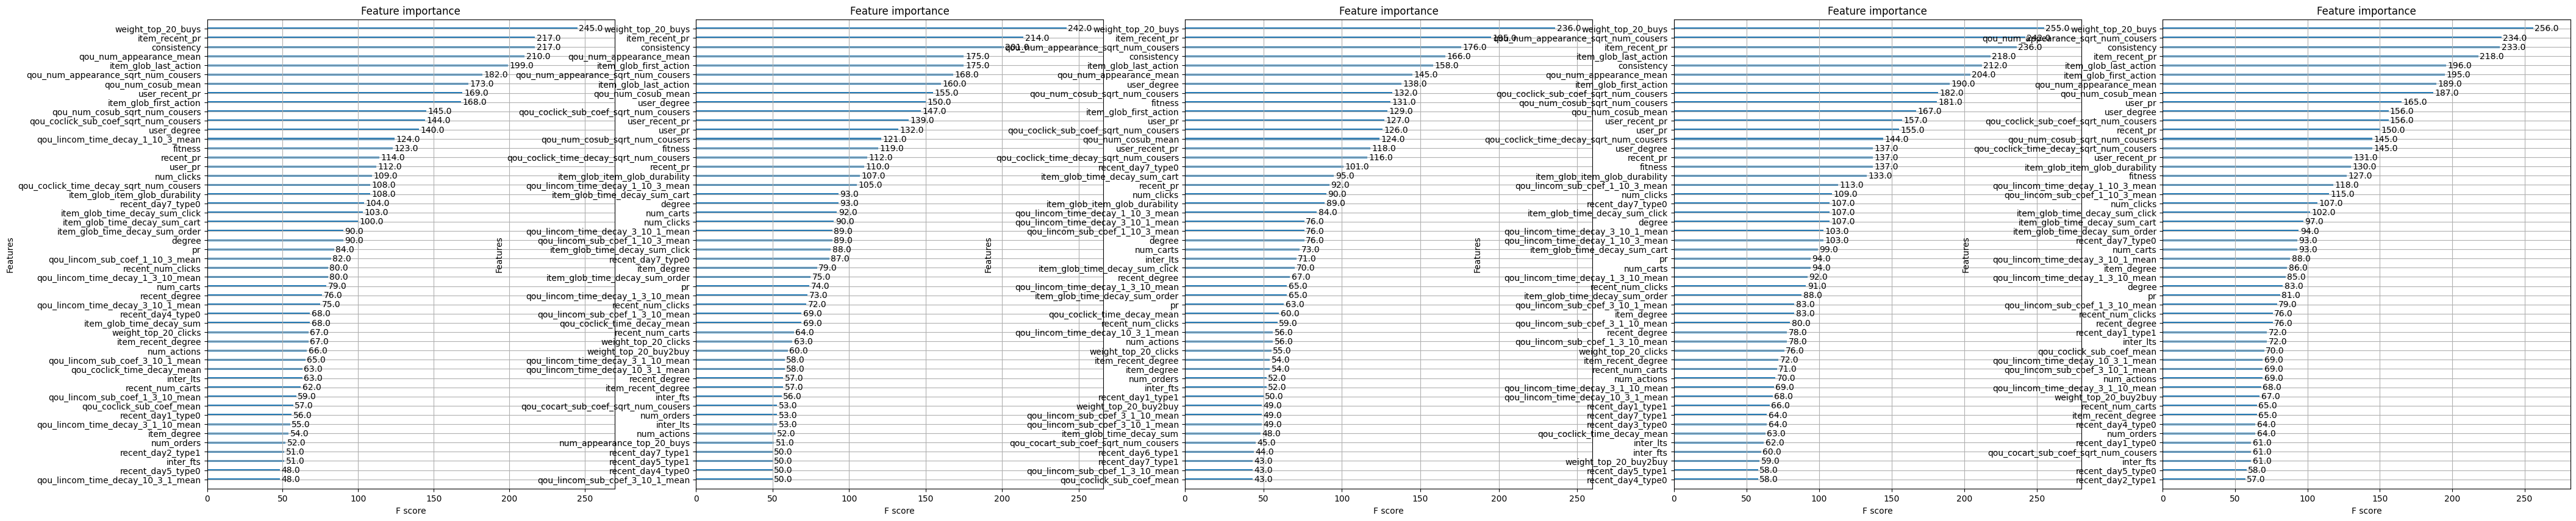

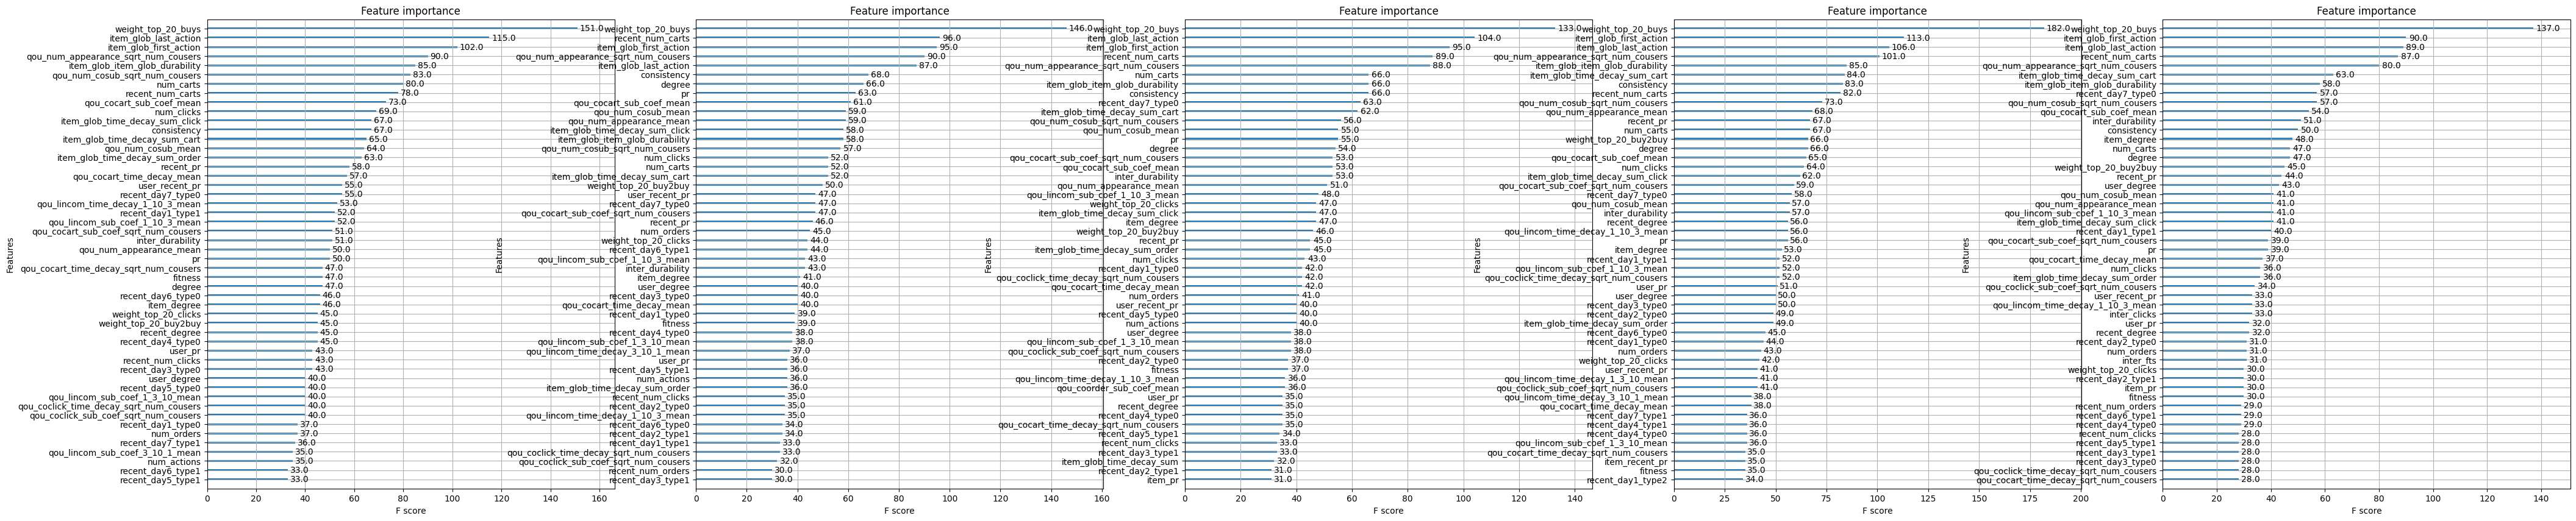

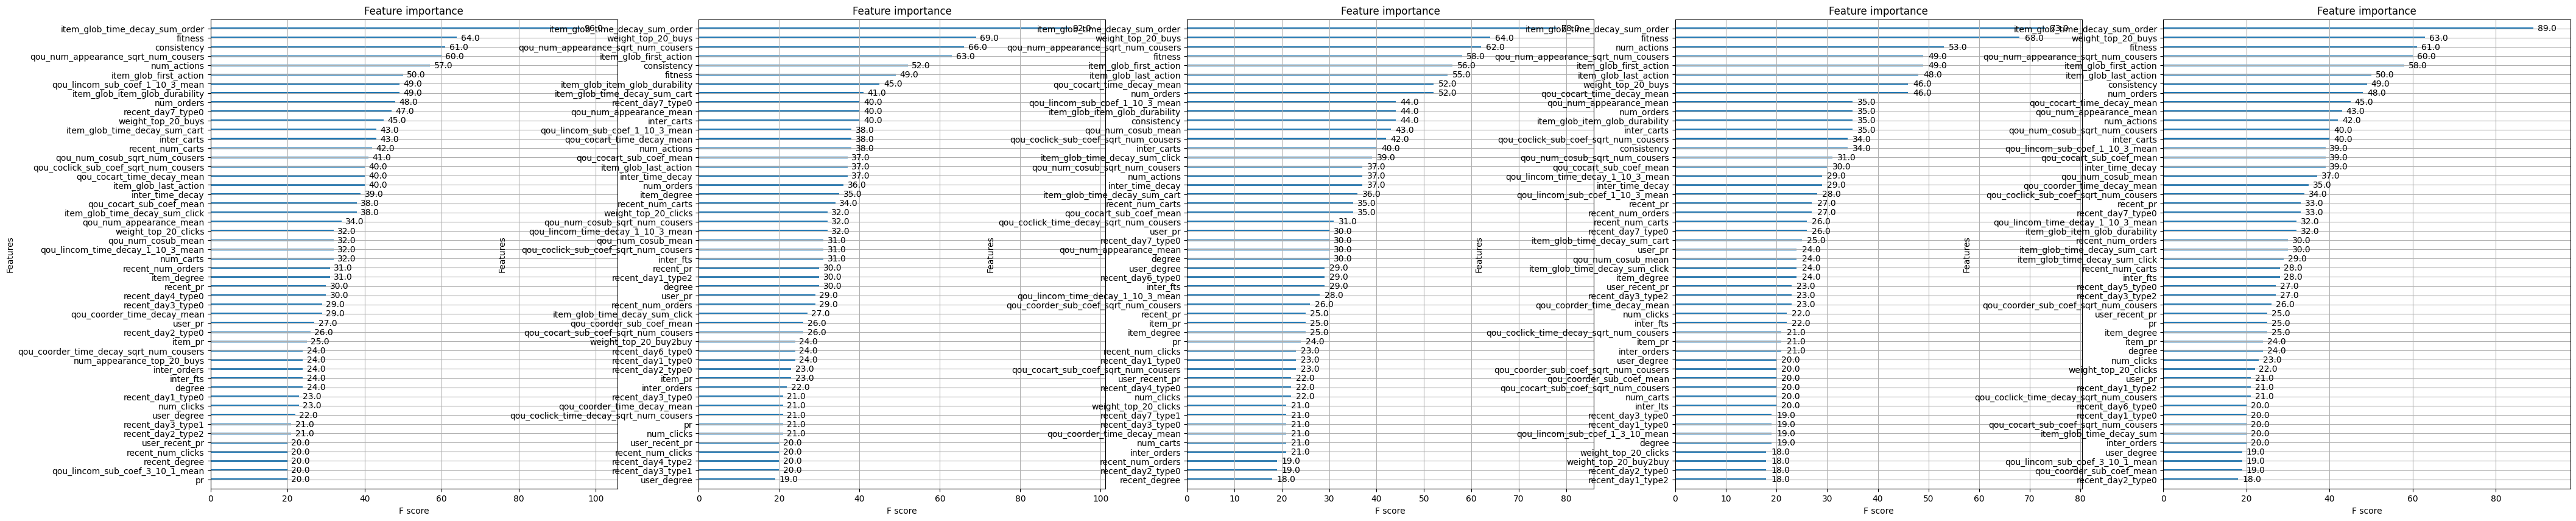

In [15]:
for id_type, t in enumerate(['clicks', 'carts', 'orders']):
  train(t, id_type)